# Python for Data Analysis Project
## YearPredictionMSD Data set
* Théophile PUISEUX 
* Nieves RODRIGUEZ ALVAR 

The Million Song Dataset (MSD) is a freely-available collection of audio features and metadata for a million contemporary popular music tracks. 
The purpose being to predict the release year of a song from audio features.

Songs in the dataset are mostly western, commercial tracks ranging from 1922 to 2011, with a peak in the year 2000s.

Due to the large spectrum of possible values (89 years) and the imbalanced data, we decide that it was better to predict the decade of the release year.

## Imports

In [ ]:
# Linear Algebra
import numpy as np
# Data processing
import pandas as pd
# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
#Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn import datasets, svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import Ridge, Lasso, LassoCV, ElasticNet,ElasticNetCV, HuberRegressor, LinearRegression,RidgeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
#Filter warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
#Autres
from google.colab import drive
import pickle
import math

## Data Import

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.read_csv("/content/drive/MyDrive/YearPredictionMSD.txt",header=None)

In [4]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,-2.46783,3.32136,-2.31521,10.20556,611.10913,951.08960,698.11428,408.98485,383.70912,326.51512,238.11327,251.42414,187.17351,100.42652,179.19498,-8.41558,-317.87038,95.86266,48.10259,-95.66303,-18.06215,1.96984,34.42438,11.72670,1.36790,7.79444,-0.36994,-133.67852,-83.26165,-37.29765,...,-25.38187,-3.90772,13.29258,41.55060,-7.26272,-21.00863,105.50848,64.29856,26.08481,-44.59110,-8.30657,7.93706,-10.73660,-95.44766,-82.03307,-35.59194,4.69525,70.95626,28.09139,6.02015,-37.13767,-41.12450,-8.40816,7.19877,-8.60176,-5.90857,-12.32437,14.68734,-54.32125,40.14786,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,4.59210,2.21920,0.34006,44.38997,2056.93836,605.40696,457.41175,777.15347,415.64880,746.47775,366.45320,317.82946,273.07917,141.75921,317.35269,19.48271,-65.25496,162.75145,135.00765,-96.28436,-86.87955,17.38087,45.90742,32.49908,-32.85429,45.10830,26.84939,-302.57328,-41.71932,-138.85034,...,28.55107,1.52298,70.99515,-43.63073,-42.55014,129.82848,79.95420,-87.14554,-45.75446,-65.82100,-43.90031,-19.45705,12.59163,-407.64130,42.91189,12.15850,-88.37882,42.25246,46.49209,-30.17747,45.98495,130.47892,13.88281,-4.00055,17.85965,-18.32138,-87.99109,14.37524,-22.70119,-58.81266,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,1.39518,2.73553,0.82804,7.46586,699.54544,1016.00954,594.06748,355.73663,507.39931,387.69910,287.15347,112.37152,161.68928,144.14353,199.29693,-4.24359,-297.00587,-148.36392,-7.94726,-18.71630,12.77542,-25.37725,9.71410,0.13843,26.79723,6.30760,28.70107,-74.89005,-289.19553,-166.26089,...,18.50939,16.97216,24.26629,-10.50788,-8.68412,54.75759,194.74034,7.95966,-18.22685,0.06463,-2.63069,26.02561,1.75729,-262.36917,-233.60089,-2.50502,-12.14279,81.37617,2.07554,-1.82381,183.65292,22.64797,-39.98887,43.37381,-31.56737,-4.88840,-36.53213,-23.94662,-84.19275,66.00518,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,-6.36304,6.63016,-3.35142,37.64085,2174.08189,697.43346,459.24587,742.78961,229.30783,387.89697,249.06662,245.89870,176.20527,98.82222,150.97286,78.49057,-62.00282,43.49659,-96.42719,-108.96608,14.22854,14.54178,-23.55608,-39.36953,-43.59209,20.83714,35.63919,-181.34947,-93.66614,-90.55616,...,4.56917,-37.32280,4.15159,12.24315,35.02697,-178.89573,82.46573,-20.49425,101.78577,-19.77808,-21.52657,3.36303,-11.63176,51.55411,-50.57576,-28.14755,-83.15795,-7.35260,-22.11505,1.18279,-122.70467,150.57360,24.37468,41.19821,-37.04318,-28.72986,162.19614,22.18309,-8.63509,85.23416,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,0.93609,1.60923,2.19223,47.32082,894.28471,809.86615,318.78559,435.04497,341.61467,334.30734,322.99589,190.61921,235.84715,96.89517,210.58870,5.60463,-199.63958,204.85812,-77.17695,-65.79741,-6.95097,-12.15262,-3.85410,20.68990,-20.30480,37.15045,11.20673,-124.09519,-295.98542,-33.31169,...,45.25506,10.42226,27.88782,-17.12676,-31.54772,-76.86293,41.17343,-138.32535,-53.96905,-21.30266,-24.87362,-2.46595,-4.05003,-56.51161,-34.56445,-5.07092,-47.75605,64.81513,-97.42948,-12.59418,55.23699,28.85657,54.53513,-31.97077,20.03279,-8.07892,-55.12617,26.58961,-10.27183,-30.64232,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.6

# Data Pre-Processing

We name all of our columns according to the dataset description.

In [5]:
df.rename(columns={0:'Year'}, inplace=True)
for i in range(91):
  if i<13 and i>0:
    df.rename(columns={i:'TimbreAvg'+str(i)}, inplace=True)
  else :
    df.rename(columns={i:'TimbreCovariance'+str(i-12)}, inplace=True)

We add the Decade variable to each song based on it's realease year.

In [6]:
df['Decade'] = df.Year.apply(lambda year : year-(year%10))

In [7]:
df.describe()

,Year,TimbreAvg1,TimbreAvg2,TimbreAvg3,TimbreAvg4,TimbreAvg5,TimbreAvg6,TimbreAvg7,TimbreAvg8,TimbreAvg9,TimbreAvg10,TimbreAvg11,TimbreAvg12,TimbreCovariance1,TimbreCovariance2,TimbreCovariance3,TimbreCovariance4,TimbreCovariance5,TimbreCovariance6,TimbreCovariance7,TimbreCovariance8,TimbreCovariance9,TimbreCovariance10,TimbreCovariance11,TimbreCovariance12,TimbreCovariance13,TimbreCovariance14,TimbreCovariance15,TimbreCovariance16,TimbreCovariance17,TimbreCovariance18,TimbreCovariance19,TimbreCovariance20,TimbreCovariance21,TimbreCovariance22,TimbreCovariance23,TimbreCovariance24,TimbreCovariance25,TimbreCovariance26,TimbreCovariance27,...,TimbreCovariance40,TimbreCovariance41,TimbreCovariance42,TimbreCovariance43,TimbreCovariance44,TimbreCovariance45,TimbreCovariance46,TimbreCovariance47,TimbreCovariance48,TimbreCovariance49,TimbreCovariance50,TimbreCovariance51,TimbreCovariance52,TimbreCovariance53,TimbreCovariance54,TimbreCovariance55,TimbreCovariance56,TimbreCovariance57,TimbreCovariance58,TimbreCovariance59,TimbreCovariance60,TimbreCovariance61,TimbreCovariance62,TimbreCovariance63,TimbreCovariance64,TimbreCovariance65,TimbreCovariance66,TimbreCovariance67,TimbreCovariance68,TimbreCovariance69,TimbreCovariance70,TimbreCovariance71,TimbreCovariance72,TimbreCovariance73,TimbreCovariance74,TimbreCovariance75,TimbreCovariance76,TimbreCovariance77,TimbreCovariance78,Decade
count,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,...,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000
mean,1998.397082,43.387126,1.289554,8.658347,1.164124,-6.553601,-9.521975,-2.391089,-1.793236,3.727876,1.882385,-0.146527,2.546063,33.714006,2439.359375,1967.734202,1514.859902,910.981344,879.146721,603.737434,517.579339,393.962215,325.733170,288.885085,291.973238,43.031969,43.314873,-46.449006,-27.672783,14.958491,44.514859,5.131786,24.034309,9.498816,-4.178856,0.499475,72.652267,-51.441256,117.921056,-189.880885,...,28.294082,12.772241,1.700474,-10.205155,64.101262,104.822085,-0.026481,38.678040,-27.989985,3.301739,0.307127,-0.478828,-138.223224,-0.696065,0.242582,3.151751,27.642745,31.822244,-0.835950,-8.931564,4.849253,-27.347646,-11.938792,-21.572137,-5.576196,-23.304324,31.113053,-104.974794,26.962393,15.755406,-73.461500,41.542422,37.934119,0.315751,17.669213,-26.315336,4.458641,20.035136,1.329105,1993.376534
std,10.931046,6.067558,51.580351,35.268585,16.322790,22.860785,12.857751,14.571873,7.963827,10.582861,6.530232,4.370848,8.320190,22.259632,1749.367690,1261.484792,1092.831044,475.708203,576.865994,317.499288,309.364735,214.013502,165.699383,186.960729,153.475649,121.429498,715.759147,544.879865,218.368476,163.215789,134.887832,99.088119,71.809934,74.411680,53.517036,42.490396,107.912629,415.039100,453.399231,260.645370,...,75.049277,69.981849,83.278660,57.806591,273.827189,311.135298,266.774027,169.072163,144.083035,59.447204,49.181425,37.675424,308.187390,222.198519,128.140961,99.920949,116.696176,106.359938,36.799193,251.606754,229.060

We then use  MinMax Scaling to normalize the data and bring every feature in the same footing without any upfront importance.


In [8]:
#MinMax Scaling
df.iloc[:,1:-1] = (df.iloc[:,1:]-df.iloc[:,1:].min())/(df.iloc[:,1:].max() - df.iloc[:,1:].min())
df.iloc[:,1:].describe()

,TimbreAvg1,TimbreAvg2,TimbreAvg3,TimbreAvg4,TimbreAvg5,TimbreAvg6,TimbreAvg7,TimbreAvg8,TimbreAvg9,TimbreAvg10,TimbreAvg11,TimbreAvg12,TimbreCovariance1,TimbreCovariance2,TimbreCovariance3,TimbreCovariance4,TimbreCovariance5,TimbreCovariance6,TimbreCovariance7,TimbreCovariance8,TimbreCovariance9,TimbreCovariance10,TimbreCovariance11,TimbreCovariance12,TimbreCovariance13,TimbreCovariance14,TimbreCovariance15,TimbreCovariance16,TimbreCovariance17,TimbreCovariance18,TimbreCovariance19,TimbreCovariance20,TimbreCovariance21,TimbreCovariance22,TimbreCovariance23,TimbreCovariance24,TimbreCovariance25,TimbreCovariance26,TimbreCovariance27,TimbreCovariance28,...,TimbreCovariance40,TimbreCovariance41,TimbreCovariance42,TimbreCovariance43,TimbreCovariance44,TimbreCovariance45,TimbreCovariance46,TimbreCovariance47,TimbreCovariance48,TimbreCovariance49,TimbreCovariance50,TimbreCovariance51,TimbreCovariance52,TimbreCovariance53,TimbreCovariance54,TimbreCovariance55,TimbreCovariance56,TimbreCovariance57,TimbreCovariance58,TimbreCovariance59,TimbreCovariance60,TimbreCovariance61,TimbreCovariance62,TimbreCovariance63,TimbreCovariance64,TimbreCovariance65,TimbreCovariance66,TimbreCovariance67,TimbreCovariance68,TimbreCovariance69,TimbreCovariance70,TimbreCovariance71,TimbreCovariance72,TimbreCovariance73,TimbreCovariance74,TimbreCovariance75,TimbreCovariance76,TimbreCovariance77,TimbreCovariance78,Decade
count,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,...,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000
mean,0.691420,0.469220,0.496370,0.317065,0.395025,0.291384,0.515292,0.354893,0.477338,0.426704,0.440923,0.530834,0.061098,0.036984,0.052901,0.047029,0.045273,0.051920,0.049144,0.053466,0.040350,0.083750,0.042010,0.029241,0.588060,0.354731,0.451340,0.555517,0.508257,0.473849,0.619332,0.443826,0.369746,0.404609,0.353260,0.424026,0.371584,0.562584,0.605835,0.486729,...,0.421871,0.573355,0.431638,0.744039,0.430914,0.292866,0.266784,0.413608,0.301818,0.512863,0.589516,0.424500,0.477124,0.719279,0.530589,0.369435,0.352972,0.269307,0.566134,0.639880,0.594996,0.795581,0.521588,0.512384,0.488434,0.494070,0.377455,0.610166,0.563242,0.354641,0.487939,0.368868,0.649008,0.567965,0.466491,0.600212,0.343834,0.503537,0.361319,1993.376534
std,0.100755,0.071524,0.056533,0.033315,0.051486,0.051839,0.040408,0.039970,0.038797,0.064036,0.027716,0.045727,0.040499,0.026616,0.034284,0.034332,0.023961,0.034283,0.026721,0.032348,0.022269,0.044704,0.027776,0.015648,0.024929,0.018900,0.020544,0.028229,0.024600,0.020227,0.016104,0.020690,0.016293,0.013649,0.015160,0.025647,0.018367,0.024974,0.016425,0.012666,...,0.017840,0.012535,0.016328,0.025540,0.022613,0.017468,0.015045,0.018426,0.017592,0.016018,0.020754,0.026673,0.014405,0.021670,0.017449,0.030707,0.015889,0.014789,0.021392,0.022841,0.019587,0.015562,0.018330,0.024267,0.018060,0.013510,0.026454,0.014813,0.014588,0.025103,0.019795,0.024342,0.019669,0.026832,0.016751,0.024320,0.019081,0.012494,0.020852,10.81583

## Data exploration

We plot the distribution of the songs per release year. We are able to see that the vast majority of the songs were released between 1990 and 2010.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Songs per release year')

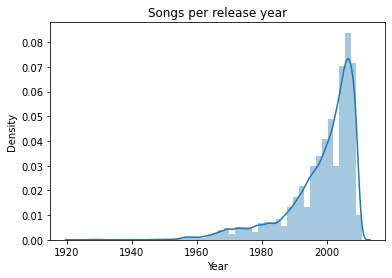

In [9]:
ax=sns.distplot(df['Year'])
plt.title("Songs per release year")

We then plot the same graph by decade. We can now see that most of the songs were released in the 90's and 2000's

Text(0.5, 1.0, 'Songs per release decade')

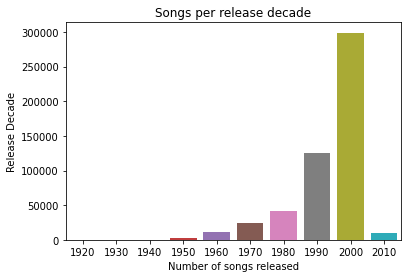

In [10]:
sns.countplot(x=df["Decade"],data=df)
plt.xlabel("Number of songs released")
plt.ylabel("Release Decade")
plt.title("Songs per release decade")

Then, we plot the correlation matrix of all of our variables.

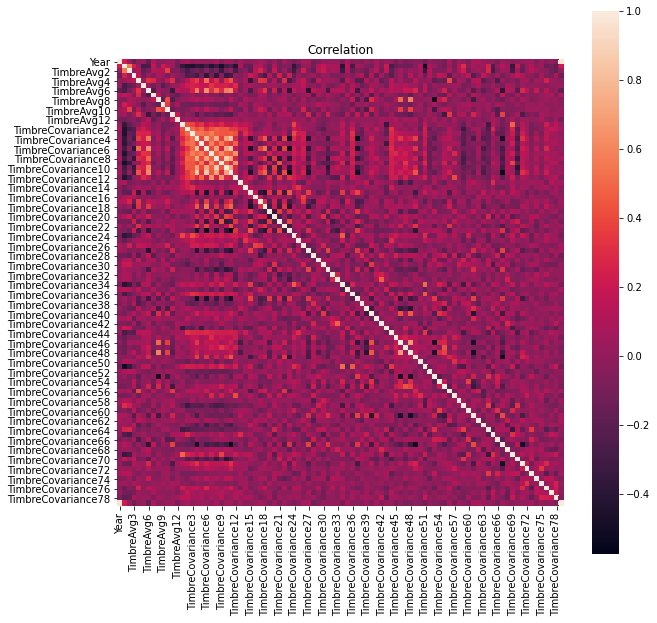

In [11]:
# Correlation between the release year and features
corr = df.iloc[:,:].corr()
fig, ax = plt.subplots(figsize=(10,10)) 
plt.title("Correlation")
x = corr[['Decade']]
sns.heatmap(corr, square=True)
plt.show()

This matrix is pretty unreadable. So we decided to plot the correlation to the Decade variable in the next graph. We can note that the results for either year or decade are the same, since decade and year are fully correlated

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


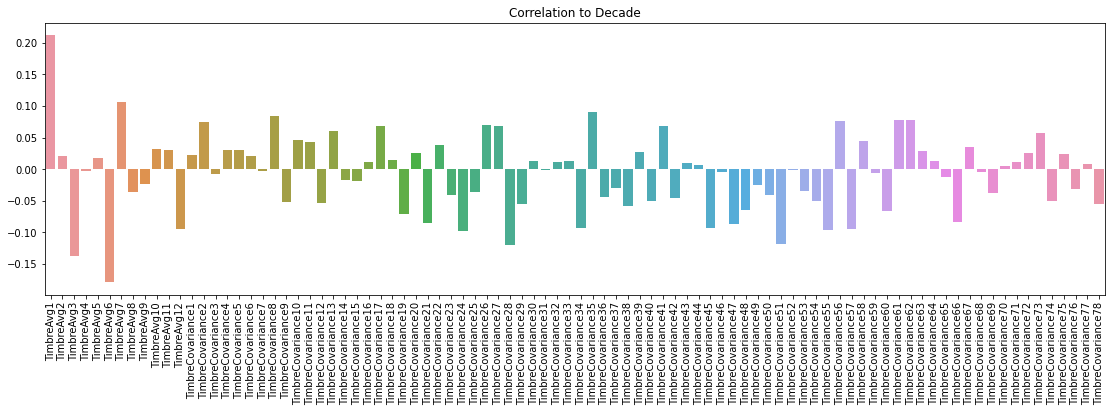

In [12]:
fig, ax = plt.subplots(figsize=(19,5)) 
sns.barplot(corr['Decade'][1:-1].index,corr['Decade'][1:-1].values).set_title('Correlation to Decade')
plt.xticks(rotation = 90)
plt.show()

We can see that the correlation between TimbreAvg1 and Decade is 0.2, which indicates that they’re  positively correlated. A higher TimbreAvg1  is related to a more recent release decade. On the opposite, variables like TimbreAvg3 and TimbreAvg6 are negatively correlated to Decade. A higher TimbreAvg3/6  is related to an older release decade



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


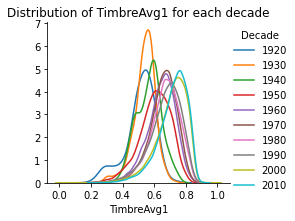

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


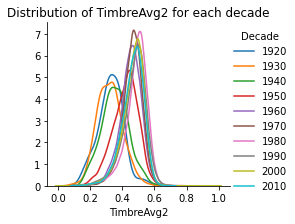

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


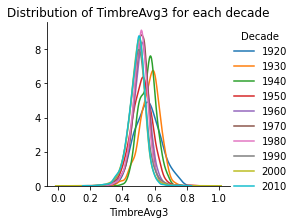

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


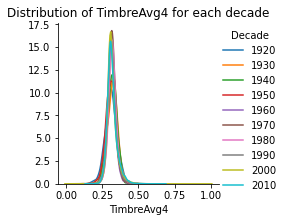

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


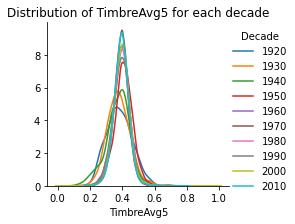

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


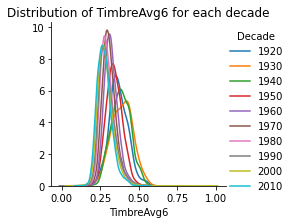

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


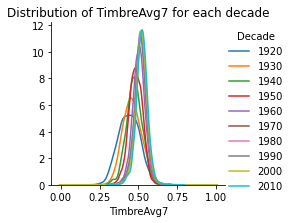

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


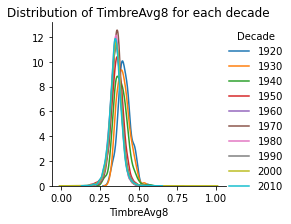

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


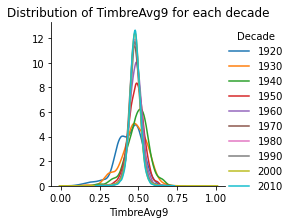

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


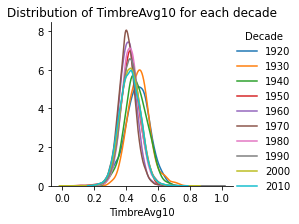

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


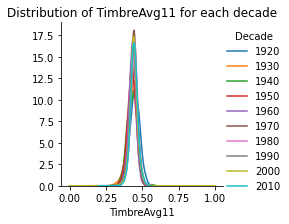

In [13]:
for component in df.columns[1:12]:
    sns.FacetGrid(df, hue="Decade", size=3) \
       .map(sns.kdeplot, component) \
       .add_legend()
    plt.title("Distribution of " + component + " for each decade")
    plt.show()

We then plot the distribution of each TimbreAvg per Decade. We can see that, like we just stated, the distribution of TimbreAvg1 in the recent years are on the right side of the plot, meaning that a higher TimbreAvg1 is related to a more recent release decade. We can say the same thing for TimbreAvg3 and TimbreAvg6 but the other way around, the recent years are on the left of the plot meaning a higher TimbreAvg3/6 is related to an older release decade.

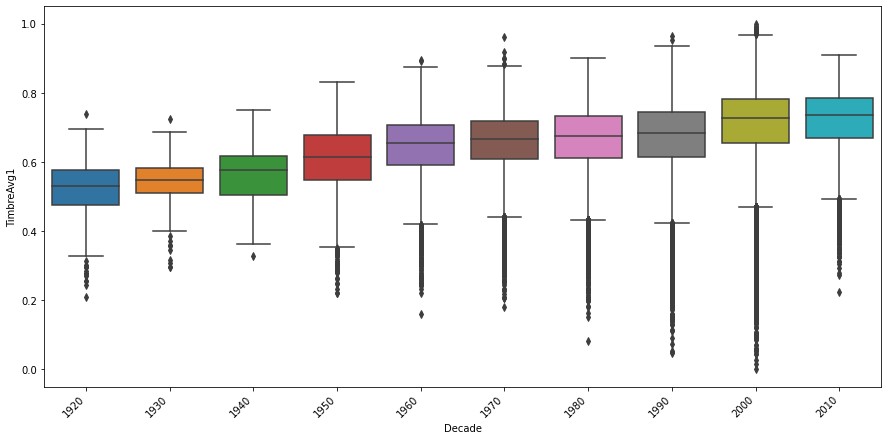

In [14]:
f, ax = plt.subplots(figsize=(15, 7))
ax = sns.boxplot(x="Decade", y="TimbreAvg1", data=df.query("Decade >= 1920 & Decade <= 2010"))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show()

## Data Preparation



As we have a lot of variables, we want to reduce the dimension of our dataset by using a PCA analysis.

In [15]:
# Separate input attributes and output into different dataframes
X = df.iloc[:,1:-1].values
y = df.iloc[:,-1].values

In [16]:
pca = PCA(n_components=20).fit(X)
X_pca = pca.transform(X)

After using the PCA algorithm, we rename all of our data to the right format and re-add the target values in the df_pca dataframe.

In [17]:
principal_components = []
samples, features = X_pca.shape
for m in range(1, features+1):
    principal_components.append("Principal Component {}".format(m))
cols = principal_components+["Decade"]    
df_pca = pd.DataFrame(np.append(X_pca, y.reshape(samples,1), axis=1), columns=cols)
df_pca["Decade"] = df_pca["Decade"].astype(int)
print("df_pca.shape = ",df_pca.shape)

df_pca.shape =  (515345, 21)


In [18]:
df_pca.head()

,Principal Component 1,Principal Component 2,Principal Component 3,Principal Component 4,Principal Component 5,Principal Component 6,Principal Component 7,Principal Component 8,Principal Component 9,Principal Component 10,Principal Component 11,Principal Component 12,Principal Component 13,Principal Component 14,Principal Component 15,Principal Component 16,Principal Component 17,Principal Component 18,Principal Component 19,Principal Component 20,Decade
0,-0.150333,-0.071206,0.035277,0.078159,0.010680,0.013303,-0.019754,-0.026421,-0.018519,-0.046062,-0.027838,0.054324,-0.008054,-0.006151,0.012393,0.006210,0.017532,0.006587,0.005171,0.016148,2000
1,-0.127587,-0.042643,-0.039528,0.030215,0.055389,-0.029257,-0.044222,-0.043036,0.024053,-0.017532,0.015779,-0.021918,0.011552,-0.023617,0.041306,0.035202,-0.008667,0.016982,0.008677,0.001483,2000
2,-0.173302,-0.032196,0.000596,0.036082,0.019382,-0.006960,-0.007132,-0.040768,-0.023654,-0.005568,-0.013685,0.002715,-0.027466,-0.001880,0.014752,0.008637,-0.006789,0.027314,-0.007172,0.001882,2000
3,-0.104943,-0.114886,0.054070,-0.024135,0.055518,-0.013095,-0.010121,-0.011147,0.000873,-0.002959,-0.028869,0.003544,0.011503,-0.005471,0.015902,0.033194,0.018365,0.022512,-0.018411,-0.007135,2000
4,-0.167919,-0.048979,0.009335,0.051351,0.022710,0.004067,-0.054792,-0.016897,0.027226,-0.020775,-0.038184,0.011443,-0.005457,-0.026870,0.029075,0.031301,-0.003883,0.011471,0.004929,0.007670,2000


We then do a Scree plot to see which components explain the most part of the variance.

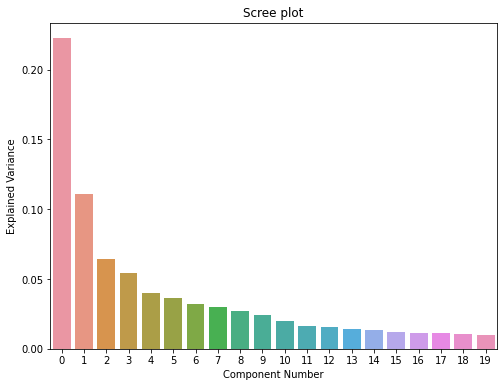

In [19]:
ind = np.arange(0, 20)
(fig, ax) = plt.subplots(figsize=(8, 6))
sns.barplot(x=ind, y=pca.explained_variance_ratio_)
ax.set_title('Scree plot')
ax.set_xticks(ind)
ax.set_xticklabels(ind)
ax.set_xlabel('Component Number')
ax.set_ylabel('Explained Variance')
plt.show()

Here we split our dataset, into train / test sets according to this split :

train: first 463,715 examples

test: last 51,630 examples

It is recommended by the dataset creator to avoids the 'producer effect' by making sure no song
from a given artist ends up in both the train and test set.

In [20]:
# Separate input attributes and output into different dataframes
X = df_pca.iloc[:,0:-1]
Y = df_pca.iloc[:,-1]

# Train set
X_train = X.iloc[0:463715,:]
y_train = Y.iloc[0:463715]

# Validation set
X_test = X.iloc[463715:,:]
y_test = Y.iloc[463715:]

Text(0.5, 1.0, 'Songs per release decade')

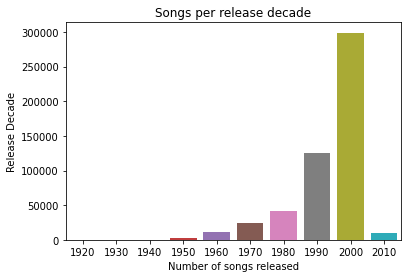

In [21]:
sns.countplot(x=df["Decade"],data=df)
plt.xlabel("Number of songs released")
plt.ylabel("Release Decade")
plt.title("Songs per release decade")

As we can see on this plot, the data is unbalanced, meaning it is inequally divided between decades. To handle this problem we wanted to use the SMOTE algorithm to be able to oversample and have a balanced dataset without loosing any information.

In [ ]:
sm = SMOTE()
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

In [23]:
X_train_res = pd.DataFrame(X_train_res)
y_train_res = pd.Series(y_train_res)
X_train_res=X_train_res[0:y_train_res.size]

But because the usage of SMOTE wasn't efficient enough and made the algorithms longer to train, we decided to head towards downsampling to have a balanced dataset.

In order to be able to downsample or filter our data according to our needs, without losing the split of the dataset creator, we merge our train and test set and resplit them later.

In [24]:
train = pd.concat([X_train,y_train], axis=1)

In [103]:
train.sample()

,Principal Component 1,Principal Component 2,Principal Component 3,Principal Component 4,Principal Component 5,Principal Component 6,Principal Component 7,Principal Component 8,Principal Component 9,Principal Component 10,Principal Component 11,Principal Component 12,Principal Component 13,Principal Component 14,Principal Component 15,Principal Component 16,Principal Component 17,Principal Component 18,Principal Component 19,Principal Component 20,Decade
333522,-0.123369,0.045646,0.048079,0.032208,-0.004566,-0.054084,0.052123,0.017608,0.044953,0.044569,-0.018643,0.001384,-0.027261,0.023486,-0.015246,0.032505,0.033259,-0.040207,0.003495,-0.027914,2000


In [26]:
test = pd.concat([X_test,y_test], axis=1)

In [102]:
test.sample()

,Principal Component 1,Principal Component 2,Principal Component 3,Principal Component 4,Principal Component 5,Principal Component 6,Principal Component 7,Principal Component 8,Principal Component 9,Principal Component 10,Principal Component 11,Principal Component 12,Principal Component 13,Principal Component 14,Principal Component 15,Principal Component 16,Principal Component 17,Principal Component 18,Principal Component 19,Principal Component 20,Decade
490119,-0.043911,0.032091,0.024173,0.099578,-0.092094,0.021073,-0.048403,-0.018766,0.030207,-0.035369,0.002064,0.012711,-0.005067,0.007102,0.014365,-0.000337,-0.020255,0.000065,-0.010298,-0.007759,2000


To train our models on all decades equally, we decided to downsample the data. To have a representative sample for each decade, we select all the songs released after 1940.

Downsampling means training on a disproportionately low subset of the majority class examples to be able to handle imbalanced data.

However, it means getting rid of useful data but we chose to continue with that because our models without downsampling were predicting only one year, which is not pertinent, and having a accuracy around 60% because a lot of our testset songs were released in 2000's.

In [28]:
test=test[test.Decade>1940]

In [29]:
#Downsampling by decade
df_t = train[train.Decade>1940]
min_samples = df_t.Decade.value_counts().min()
decades = df_t.Decade.unique()
df_sampled = pd.DataFrame(columns=df_t.columns)
for decade in decades:
    df_sampled = df_sampled.append(df_t[df_t.Decade==decade].sample(min_samples))
df_sampled.Decade = df_sampled.Decade.astype(int)

In [30]:
df_sampled.reset_index(inplace=True, drop=True)

In [31]:
df_sampled.head()

,Principal Component 1,Principal Component 2,Principal Component 3,Principal Component 4,Principal Component 5,Principal Component 6,Principal Component 7,Principal Component 8,Principal Component 9,Principal Component 10,Principal Component 11,Principal Component 12,Principal Component 13,Principal Component 14,Principal Component 15,Principal Component 16,Principal Component 17,Principal Component 18,Principal Component 19,Principal Component 20,Decade
0,0.109038,0.268865,0.022298,-0.054208,0.012870,-0.002805,-0.022350,-0.019106,0.009894,0.029089,-0.060299,-0.023270,-0.012736,0.022744,-0.059794,0.018762,-0.074209,0.003182,0.023910,-0.024517,2000
1,-0.096892,-0.052597,0.109509,-0.018071,0.005383,0.025808,0.022537,-0.024758,-0.010506,0.015848,0.002041,-0.027114,0.023766,-0.025192,0.002467,0.003564,0.006653,0.037909,-0.012176,-0.012829,2000
2,-0.021108,0.062805,0.057592,-0.089188,0.000601,-0.033943,-0.034807,-0.112094,-0.036601,-0.031806,-0.017382,0.036811,0.033439,0.022471,-0.009491,0.009359,0.048111,0.009706,0.024480,-0.025120,2000
3,0.130709,0.012677,0.025144,0.025755,0.066956,0.086956,-0.042289,-0.025041,0.014394,-0.026126,0.004166,-0.054262,0.029035,0.025478,-0.038801,-0.002651,-0.026832,0.016732,-0.046387,0.009425,2000
4,0.032922,-0.040736,0.005101,-0.058229,0.048921,0.042229,-0.001969,0.040326,0.037342,-0.014504,-0.014902,-0.013659,-0.008388,-0.007437,-0.012129,-0.047863,0.007171,0.024390,0.002691,0.024830,2000


We plot  the distribution of the songs per release decade to check if our downsampling worked properly.

Text(0.5, 1.0, 'Downsampled dataset')

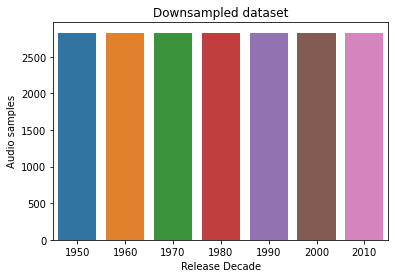

In [32]:
sns.countplot(x="Decade", data=df_sampled)
plt.ylabel("Audio samples")
plt.xlabel("Release Decade")
plt.title("Downsampled dataset")

Now that the downsampling is completed, we split our data back to X_test, y_test, X_train, y_train

In [33]:
# Test set
X_test = test.iloc[:,:-1]
y_test = test.iloc[:,-1]

In [34]:
# Train set
X_train = df_sampled.iloc[:,:-1]
y_train = df_sampled.iloc[:,-1]

# Model Building


## Classification

In order to have an efficient and unified way to call our classification models, we designed a function to call any scikit-learn classification models and plot the results.

For each model, we decided to plot :

* Predicted vs Original values : This plot shows, in red, the values predicted by the model for each sample of the test set and the original values in blue.

* Relative distribution : This plot shows, in red, the sum of predicted values for the distinct years and in dark blue, the sum of original values for the distinct years. This plot is really useful because it allows us to determine if our model only predicts mean values or if it predicts on the entire spectrum of possible values.


In [35]:
def models(modelName):
  name = str(modelName).split("(")[0]
  model = modelName.fit(X_train, y_train)
  ypred = np.round(model.predict(X_test),0)
  score = model.score(X_test, y_test)
  print("Model : " + name)
  print("Score: " + str(score))
  # save the model to disk
  filename = 'finalized_modelCls'+str(modelName)[0:10]+'.sav'
  pickle.dump(model, open(filename, 'wb'))

  fig, ax = plt.subplots(figsize=(12,8))
  x_ax = range(len(X_test))
  plt.scatter(x_ax, y_test, s=3, color="blue", label="original")
  plt.plot(x_ax, ypred, lw=0.8, color="red", label="predicted")  
  plt.title('Predicted vs Original values for ' + name)
  plt.legend()
  plt.show()

  
  # plot the relative distribution of the current model
  fig, ax = plt.subplots(figsize=(12,8))
  plt.hist(ypred, color='red', alpha=0.5, label='Prediction')
  plt.hist(y_test, color='darkblue', alpha=0.5, label='True year')
  plt.legend()
  plt.title('Relative distribution with ' + name)
  plt.xlabel('Relative')
  plt.ylabel('Count')
  plt.show()

> Decision Tree Classifier

Decision Trees (DTs) are a non-parametric supervised learning method used for classification and regression. Decision trees learn from data to approximate a sine curve with a set of if-then-else decision rules. The deeper the tree, the more complex the decision rules and the fitter the model.


In [36]:
depths = [5,6,7,8,9,10,15,20]
for d in depths:
  model = DecisionTreeClassifier(max_depth=d).fit(X_train,y_train) 
  score = model.score(X_test, y_test)
  pred_y = model.predict(X_test)
  print("Depth:{0:.6f}, Score:{1:.3f}"
      .format(d, score))

Depth:5.000000, Score:0.080
Depth:6.000000, Score:0.114
Depth:7.000000, Score:0.149
Depth:8.000000, Score:0.215
Depth:9.000000, Score:0.236
Depth:10.000000, Score:0.234
Depth:15.000000, Score:0.228
Depth:20.000000, Score:0.224


Model : DecisionTreeClassifier
Score: 0.23620381868984788


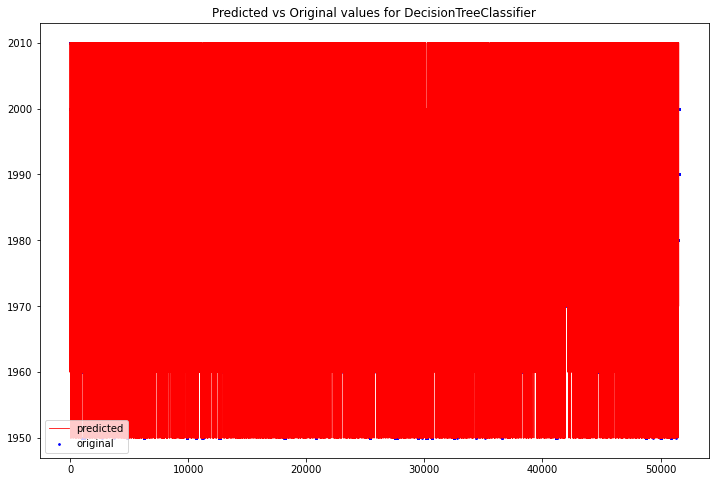

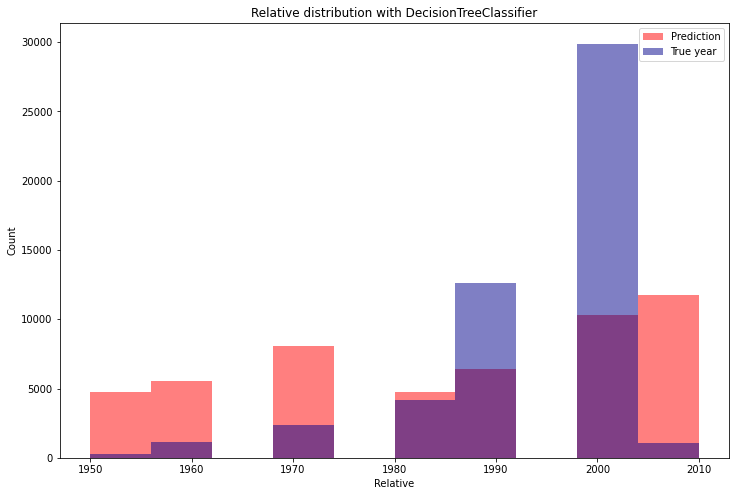

In [63]:
models(DecisionTreeClassifier(max_depth=9))

> SVC

C-Support Vector Classification. The implementation is based on libsvm. The fit time scales at least quadratically with the number of samples and may be impractical beyond tens of thousands of samples.

In [ ]:
'''grid_search = GridSearchCV(svm.SVC(),
                           {'kernel':['linear', 'rbf','poly'], 
                            'C': [1, 5, 10,15,20,25], 
                            'gamma' : [1, 5, 10,15,20]
                           },
                           cv=None)
grid_search.fit(X_train, y_train)
clf = grid_search.best_estimator_
print(clf)'''

The gridsearch returned the parameters :
* kernel = rbf
* c = 1
* gama = 15

Model : SVC
Score: 0.31550760633343683


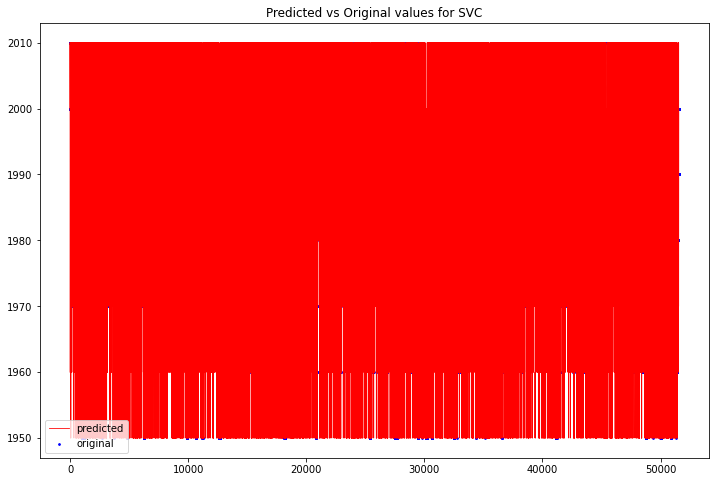

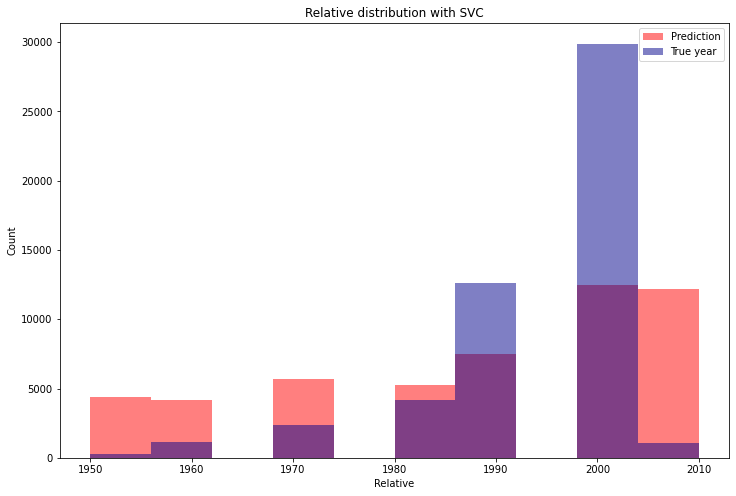

In [40]:
models(svm.SVC(kernel='rbf',C=1,gamma=15))

> Random Forest Classifier

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is controlled with the max_samples parameter, otherwise the whole dataset is used to build each tree.

In [62]:
depths = [5,10,15,20]
n_est=[10,100,200]
for d in depths:
  for n in n_est:
    model = RandomForestClassifier(n_estimators=n,max_depth=d, random_state=0).fit(X_train,y_train) 
    score = model.score(X_test, y_test)
    pred_y = model.predict(X_test)
    print("N_estimators:{0:.0f},Depth:{1:.0f}, Score:{2:.4f}"
        .format(n,d, score))

N_estimators:10,Depth:5, Score:0.1701
N_estimators:100,Depth:5, Score:0.1487
N_estimators:200,Depth:5, Score:0.1496
N_estimators:10,Depth:10, Score:0.2520
N_estimators:100,Depth:10, Score:0.2448
N_estimators:200,Depth:10, Score:0.2490
N_estimators:10,Depth:15, Score:0.2595
N_estimators:100,Depth:15, Score:0.2766
N_estimators:200,Depth:15, Score:0.2781
N_estimators:10,Depth:20, Score:0.2463
N_estimators:100,Depth:20, Score:0.2774
N_estimators:200,Depth:20, Score:0.2844


Model : RandomForestClassifier
Score: 0.2843837317603229


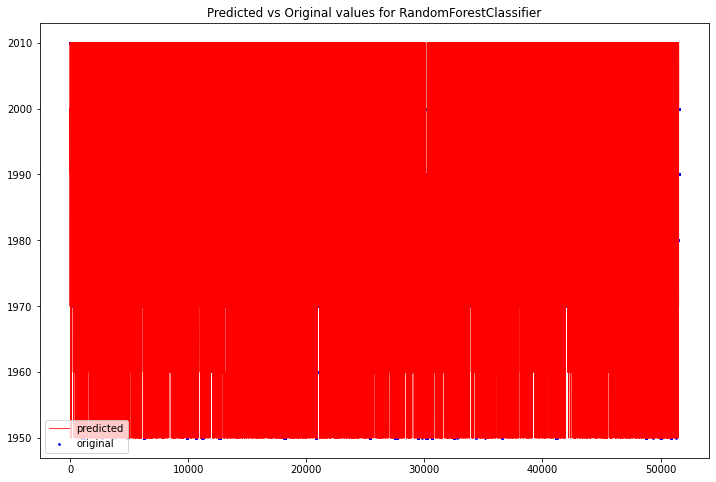

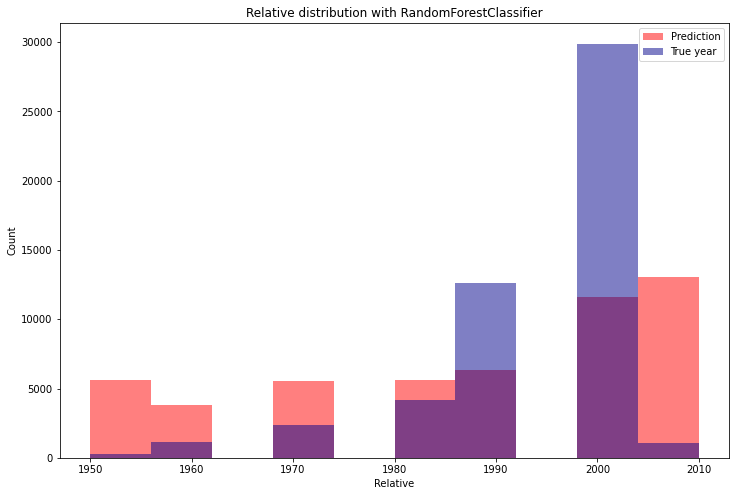

In [45]:
models(RandomForestClassifier(n_estimators=200,max_depth=20, random_state=0))

In [99]:
model = RandomForestClassifier(n_estimators=200,max_depth=20, random_state=0).fit(X_train, y_train)
importances = model.feature_importances_
indices = np.argsort(importances)

Text(0.5, 0, 'Relative Importance')

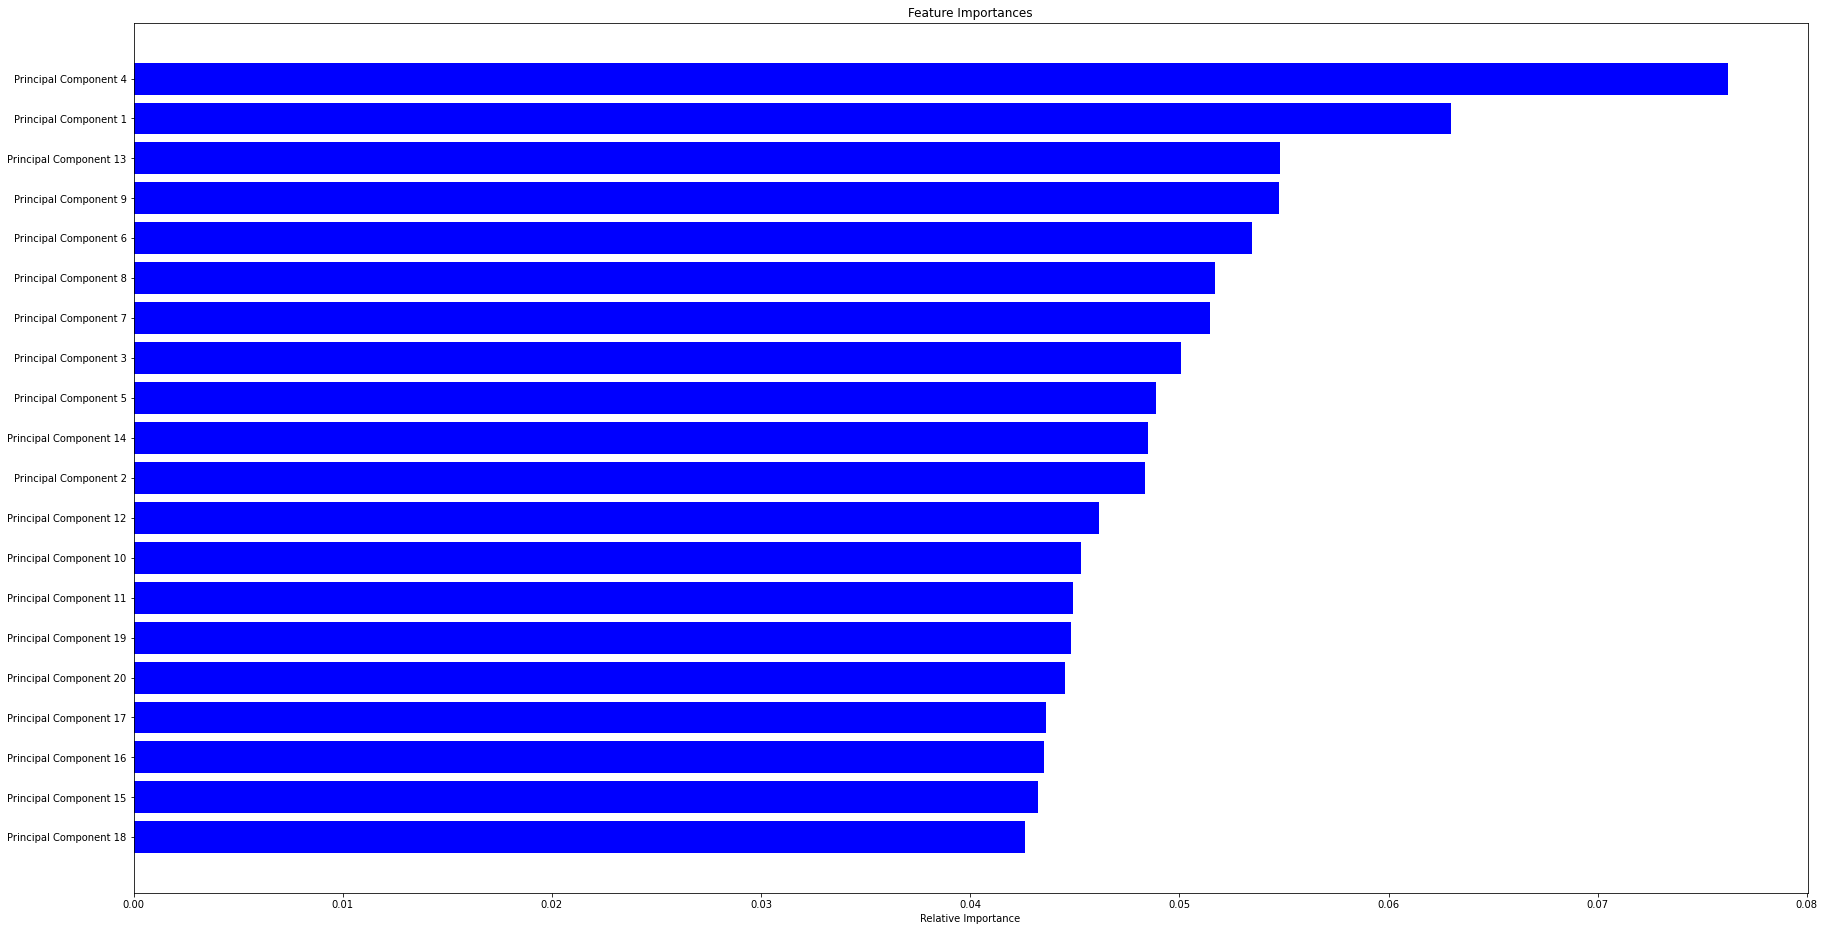

In [100]:
plt.figure(figsize=(30,16))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), train.columns[indices])
plt.xlabel('Relative Importance')

> Ridge Classifier

This classifier first converts the target values into {-1, 1} and then treats the problem as a regression task (multi-output regression in the multiclass case).

Ridge method applies L2 regularization to reduce overfitting in the regression model.

This model solves a regression model where the loss function is the linear least squares function and regularization is given by the l2-norm.

Best alphas
Alpha is an important factor in regularization. It defines Ridge shrinkage or regularization strength. The higher value means the stronger regularization. We don't know which value works efficiently for our regularization method. Thus we'll figure out the best alpha value by checking the model accuracy with setting multiple alpha values.

We can define Ridge model by setting alpha and fit it with x, y data. Then we check the R-squared, MSE, RMSE values for each alpha.

After testing the different alphas, we'll define the Ridge model again with alpha = 0 as the MSE is at its lowest point.

In [58]:
alphas = [0, 0.1,0.5, 1,5,10]
for a in alphas:
  model = RidgeClassifier(alpha=a).fit(X_train,y_train) 
  score = model.score(X_test, y_test)
  pred_y = model.predict(X_test)
  print("Alpha:{0:.6f}, Score:{1:.3f}"
      .format(a, score))

Alpha:0.000000, Score:0.184
Alpha:0.100000, Score:0.184
Alpha:0.500000, Score:0.182
Alpha:1.000000, Score:0.180
Alpha:5.000000, Score:0.170
Alpha:10.000000, Score:0.160


Model : RidgeClassifier
Score: 0.18398789195901893


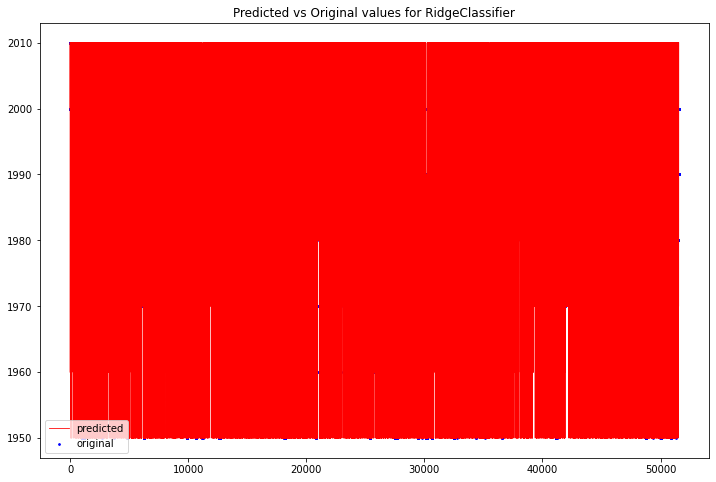

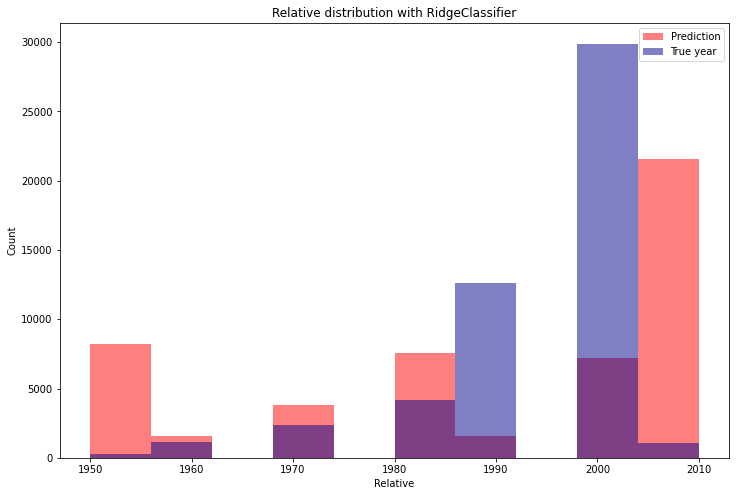

In [98]:
models(RidgeClassifier(alpha=0))

In order to have an efficient and unified way to call our Regression models, we designed a function to call any scikit-learn regression models and plot the results.

For each model, we decided to plot :

* Predicted vs Original values : This plot shows, in red, the values predicted by the model for each sample of the test set and the original values in blue.

* Relative distribution : This plot shows, in red, the sum of predicted values for the distinct years and in dark blue, the sum of original values for the distinct years. This plot is really useful because it allows us to determine if our model only predicts mean values or if it predicts on the entire spectrum of possible values.


 ## Regression

In [104]:
def modelsReg(modelName):
  name = str(modelName).split("(")[0]
  model = modelName.fit(X_train, y_train)
  ypred = np.round(model.predict(X_test),-1)
  mse = mean_squared_error(y_test, ypred)
  print("Model : " + name)
  print("MSE: " + str(mse))
  print("RMSE: " + str(math.sqrt(mse)))
  
  # save the model to disk
  filename = 'modReg'+str(modelName)[0:10]+'.sav'
  pickle.dump(model, open(filename, 'wb'))

  fig, ax = plt.subplots(figsize=(12,8))
  x_ax = range(len(X_test))
  plt.scatter(x_ax, y_test, s=3, color="blue", label="original")
  plt.plot(x_ax, ypred, lw=0.8, color="red", label="predicted")  
  plt.title('Predicted vs Original values for ' + name)
  plt.legend()
  plt.show()

  
  # plot the relative distribution of the current model
  fig, ax = plt.subplots(figsize=(12,8))
  plt.hist(ypred, color='red', alpha=0.5, label='Prediction')
  plt.hist(y_test, color='darkblue', alpha=0.5, label='True year')
  plt.legend()
  plt.title('Relative distribution with ' + name)
  plt.xlabel('Relative')
  plt.ylabel('Count')
  plt.show()

A Random Forest is an ensemble technique capable of performing both regression and classification tasks with the use of multiple decision trees and a technique called Bootstrap Aggregation, commonly known as bagging. Bagging, in the Random Forest method, involves training each decision tree on a different data sample where sampling is done with replacement.

The basic idea behind this is to combine multiple decision trees in determining the final output rather than relying on individual decision trees.

In [68]:
depths = [5,10,15,20]
n_est=[10,100,200]
for d in depths:
  for n in n_est:
    model = RandomForestRegressor(n_estimators=n,max_depth=d).fit(X_train,y_train) 
    score = model.score(X_test, y_test)
    pred_y = model.predict(X_test)
    mse = mean_squared_error(y_test, pred_y)
    rmse = math.sqrt(mse)
    print("N_estimators:{0:.0f},Depth:{1:.0f}, MSE:{2:.4f}, RMSE:{3:.4f}"
        .format(n,d, mse, rmse))

N_estimators:10,Depth:5, MSE:225.2300, RMSE:15.0077
N_estimators:100,Depth:5, MSE:223.3948, RMSE:14.9464
N_estimators:200,Depth:5, MSE:222.4226, RMSE:14.9138
N_estimators:10,Depth:10, MSE:204.7328, RMSE:14.3085
N_estimators:100,Depth:10, MSE:195.5595, RMSE:13.9843
N_estimators:200,Depth:10, MSE:194.4762, RMSE:13.9455
N_estimators:10,Depth:15, MSE:208.7551, RMSE:14.4484
N_estimators:100,Depth:15, MSE:188.9565, RMSE:13.7461
N_estimators:200,Depth:15, MSE:188.3869, RMSE:13.7254
N_estimators:10,Depth:20, MSE:206.2534, RMSE:14.3615
N_estimators:100,Depth:20, MSE:186.8191, RMSE:13.6682
N_estimators:200,Depth:20, MSE:185.6318, RMSE:13.6247


Model : RandomForestRegressor
MSE: 193.68596709096553
RMSE: 13.917110587006396


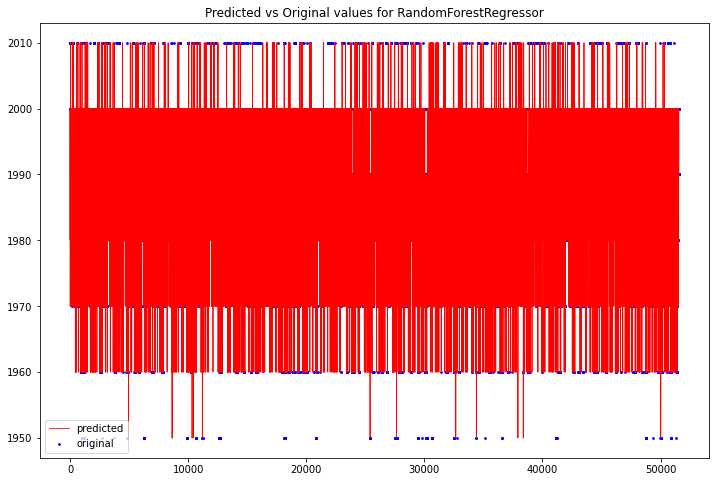

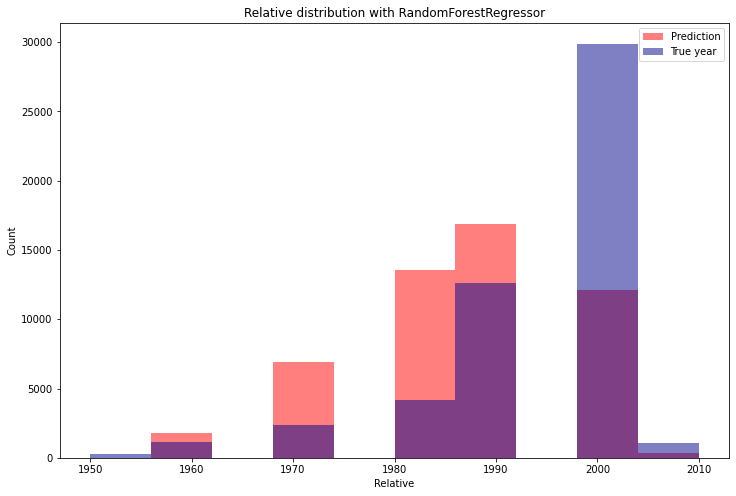

In [72]:
modelsReg(RandomForestRegressor(n_estimators=200,max_depth=20))

Linear regression is a simple machine learning algorithm that builds a model to identify the relationship between independent (predictor) and dependent (response) variables.

It fits a linear model with coefficients w = (w1, …, wp) to minimize the residual sum of squares between the observed targets in the dataset, and the targets predicted by the linear approximation.

Model : LinearRegression
MSE: 229.94217634275068
RMSE: 15.163844378743494


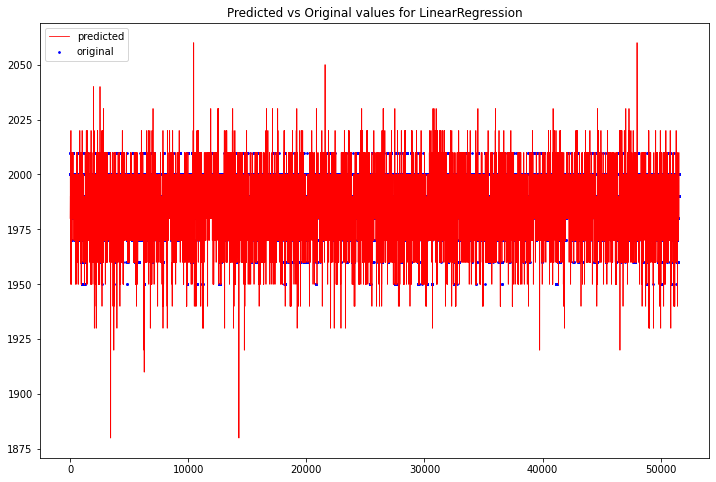

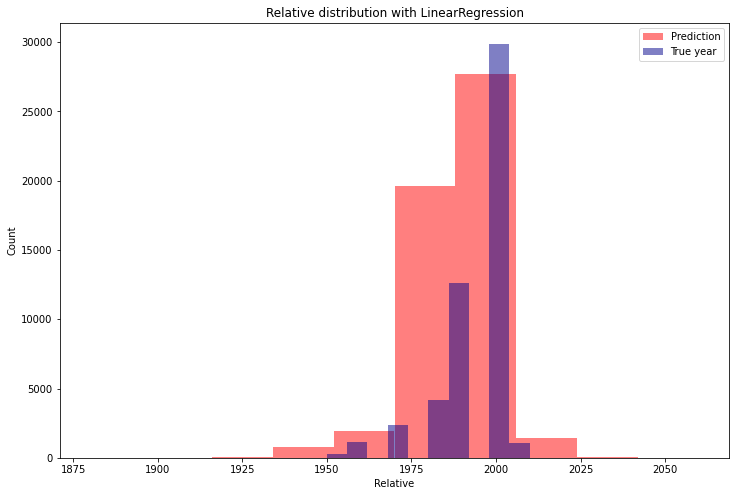

In [89]:
modelsReg(LinearRegression())

LASSO (Least Absolute Shrinkage and Selection Operator) is a regularization method to minimize overfitting in a model. It reduces large coefficients with L1-norm regularization which is the sum of their absolute values. The penalty pushes the coefficients with lower value to be zero, to reduce the model complexity.

LassoCV applies cross-validation method to find out the best model. We'll set multiple alpha values and to train the model.

After testing the different alphas, we'll define the Ridge model again with alpha = 0.0001 as the MSE is at its lowest point.

In [83]:
alphas = [0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 1]
for a in alphas:
  model = LassoCV(alphas=[a]).fit(X_train,y_train) 
  score = model.score(X_test, y_test)
  pred_y = model.predict(X_test)
  mse = mean_squared_error(y_test, pred_y)
  rmse = math.sqrt(mse)
  print("alpha:{0:.4f}, MSE:{1:.4f}, RMSE:{2:.4f}"
      .format(a, mse, rmse))

alpha:0.0001, MSE:221.0054, RMSE:14.8663
alpha:0.0010, MSE:220.6991, RMSE:14.8559
alpha:0.0100, MSE:218.7622, RMSE:14.7906
alpha:0.1000, MSE:243.9089, RMSE:15.6176
alpha:0.3000, MSE:263.0009, RMSE:16.2173
alpha:0.5000, MSE:280.7654, RMSE:16.7561
alpha:0.7000, MSE:287.3090, RMSE:16.9502
alpha:1.0000, MSE:292.9059, RMSE:17.1145


Model : LassoCV
MSE: 229.84709717479043
RMSE: 15.160708993143771


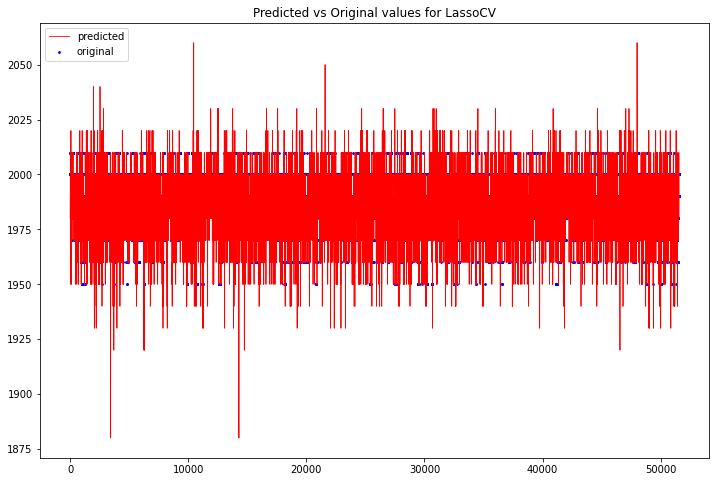

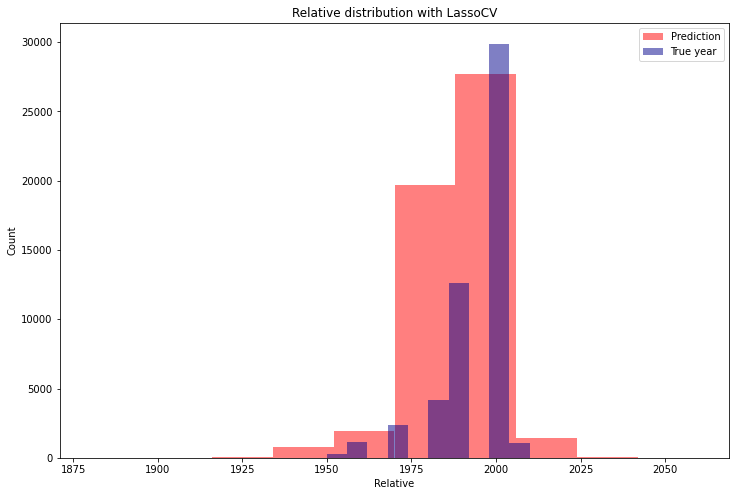

In [93]:
modelsReg(LassoCV(alphas=[0.001]))

ElasticNet regularization applies both L1-norm and L2-norm regularization to penalize the coefficients in a regression model.

To figure out what alpha value is good for our model, we'll define multiple values and check the performance accuracy.

alphas = [0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 1]

We define ElasticNet model by setting alpha and train it with x and y data. Then, we'll check the R-squared, MSE, and RMSE metrics for each alpha.

In [95]:
alphas = [0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 1]
for a in alphas:
  model = ElasticNetCV(alphas=[a]).fit(X_train,y_train) 
  score = model.score(X_test, y_test)
  pred_y = model.predict(X_test)
  mse = mean_squared_error(y_test, pred_y)
  rmse = math.sqrt(mse)
  print("alpha:{0:.4f}, MSE:{1:.4f}, RMSE:{2:.4f}"
      .format(a, mse, rmse))

alpha:0.0001, MSE:220.0041, RMSE:14.8325
alpha:0.0010, MSE:216.3176, RMSE:14.7077
alpha:0.0100, MSE:232.8011, RMSE:15.2578
alpha:0.1000, MSE:276.1309, RMSE:16.6172
alpha:0.3000, MSE:287.9007, RMSE:16.9676
alpha:0.5000, MSE:290.3879, RMSE:17.0408
alpha:0.7000, MSE:291.4942, RMSE:17.0732
alpha:1.0000, MSE:292.3350, RMSE:17.0978


Model : ElasticNetCV
MSE: 229.03019248680533
RMSE: 15.133743505385748


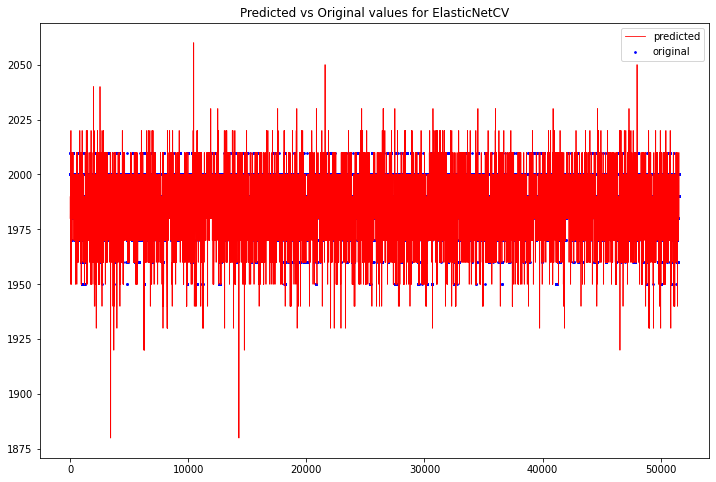

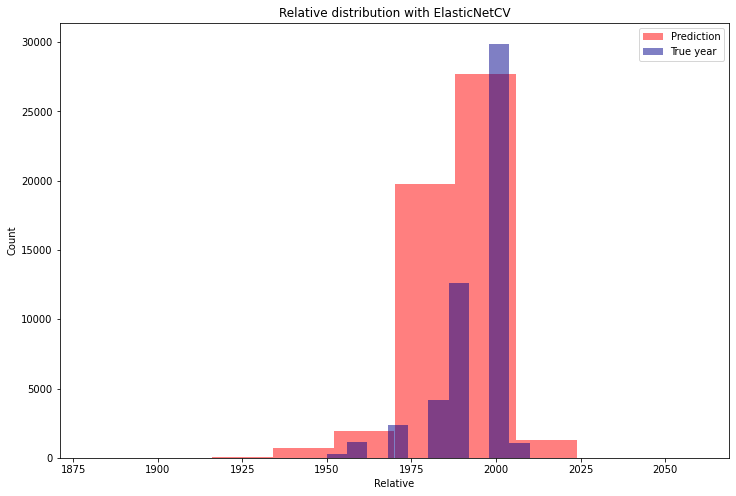

In [97]:
modelsReg(ElasticNetCV(alphas=[0.0001]))